In [ ]:
import numpy as np
from typing import Optional, Union, Tuple
import pandas as pd
from scipy.linalg import inv, pinv
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

In [ ]:
def calculate_G_matrix(M: np.ndarray, 
                      method: str = "vanraden1", 
                      missing_value: Optional[Union[int, float]] = None,
                      min_maf: float = 0.01) -> np.ndarray:
    """
    Calculate the genomic relationship matrix G using VanRaden (2008) methods.
    
    Parameters:
    -----------
    M : numpy.ndarray
        Genotype matrix with dimensions (n, m), 
        where n is the number of individuals, m is the number of markers.
        M_ij is the genotype of individual i at marker j (0, 1, 2).
    method : str, optional
        Method to calculate G matrix. Options:
        - "vanraden1": G = ZZ'/total_variance (default)
        - "vanraden2": G = (M-P)(M-P)'/sum(2pq)
    missing_value : int or float, optional
        Value used to represent missing genotypes. If provided, will be replaced with mean.
    min_maf : float, optional
        Minimum minor allele frequency threshold. Markers with MAF < min_maf will be excluded.
        Default is 0.01 (1%).
    
    Returns:
    --------
    G : numpy.ndarray
        Genomic relationship matrix G with dimensions (n, n).
    
    References:
    -----------
    VanRaden, P. M. (2008). Efficient methods to compute genomic predictions.
    Journal of Dairy Science, 91(11), 4414-4423.
    """
    # Get the dimensions of matrix M
    n, m = M.shape  # n: number of individuals, m: number of markers
    
    # Handle missing values if specified
    M_clean = M.copy()
    if missing_value is not None:
        mask = M_clean == missing_value
        if np.any(mask):
            for j in range(m):
                col_mask = mask[:, j]
                if np.any(col_mask):
                    # Replace missing with mean of non-missing values
                    non_missing = M_clean[~col_mask, j]
                    if len(non_missing) > 0:
                        M_clean[col_mask, j] = np.mean(non_missing)
    
    # Step 1: Calculate allele frequency p_j for each marker
    p = np.sum(M_clean, axis=0) / (2 * n)  # Minor allele frequency
    
    # Filter markers by MAF
    valid_markers = np.where((p >= min_maf) & (p <= 1 - min_maf))[0]
    if len(valid_markers) < m:
        print(f"Filtered out {m - len(valid_markers)} markers with MAF < {min_maf}")
        if len(valid_markers) == 0:
            raise ValueError(f"No markers left after MAF filtering. Consider lowering min_maf.")
        M_clean = M_clean[:, valid_markers]
        p = p[valid_markers]
        m = len(valid_markers)
    
    # Step 2: Create matrix P with P_ij = 2 * p_j
    P = np.tile(2 * p, (n, 1))  # Create n x m matrix from vector 2*p
    
    # Step 3: Calculate matrix Z = M - P
    Z = M_clean - P
    
    # Step 4: Calculate denominator (total variance)
    total_variance = np.sum(2 * p * (1 - p))
    
    # Method implementation
    if method.lower() == "vanraden1":
        
        # Step 5: Normalize Z
        std_dev = np.sqrt(2 * p * (1 - p))
        # Avoid division by zero (for very low variance markers)
        std_dev[std_dev < 1e-10] = 1e-10
        W = Z / std_dev
        
        # Calculate G matrix
        G = np.dot(W, W.T) / total_variance
        
    elif method.lower() == "vanraden2":
        # Alternative method directly using Z
        G = np.dot(Z, Z.T) / total_variance
        
    else:
        raise ValueError(f"Unknown method: {method}. Use 'vanraden1' or 'vanraden2'.")
    
    return G

# Example usage
if __name__ == "__main__":
    # Sample genotype matrix (3 individuals, 4 markers)
    M_sample = np.array([
        [0, 1, 2, 1],
        [1, 2, 1, 0],
        [2, 1, 0, 1]
    ])
    G = calculate_G_matrix(M_sample)
    print("G matrix:")
    print(G)
    
    # With missing values (coded as -9)
    M_missing = np.array([
        [0, 1, 2, -9],
        [1, -9, 1, 0],
        [2, 1, -9, 1]
    ])
    G_imputed = calculate_G_matrix(M_missing, missing_value=-9, method="vanraden1")
    print("\nG matrix with imputed missing values:")
    print(G_imputed)

In [65]:
import numpy as np
from scipy.linalg import inv, cholesky

def greml(G, X, Z, y, max_iter=500, tol=1e-3):
    """
    Hàm thực hiện GREML (EM-REML) để ước tính phương sai genomic và phương sai sai số.
    
    Đầu vào:
        G: Ma trận quan hệ genomic (q x q)
        X: Ma trận thiết kế cho hiệu ứng cố định (n x p)
        Z: Ma trận thiết kế cho hiệu ứng ngẫu nhiên (n x q)
        y: Vector phenotype (n x 1)
        max_iter: Số lần lặp tối đa
        tol: Ngưỡng hội tụ
    
    Đầu ra:
        sigma_g2: Phương sai genomic
        sigma_e2: Phương sai sai số
    """
    n = len(y)  # Số quan sát
    q = G.shape[0]  # Số hiệu ứng ngẫu nhiên
    
    # Khởi tạo giá trị ban đầu
    var_y = np.var(y)
    sigma_g2 = var_y / 2
    sigma_e2 = var_y / 2
    print(f"Khởi tạo: σ²_g = {sigma_g2}, σ²_e = {sigma_e2}")

    for iteration in range(max_iter):
        # Tính ma trận V
        V = Z @ G @ Z.T * sigma_g2 + np.eye(n) * sigma_e2
        
        # Tính V_inv bằng phân rã Cholesky
        try:
            L = cholesky(V, lower=True)
            V_inv = inv(L.T) @ inv(L)
        except np.linalg.LinAlgError:
            print("Ma trận V không khả nghịch")
            return None, None
        
        # Tính P
        X_V_inv = X.T @ V_inv
        P = V_inv - V_inv @ X @ inv(X_V_inv @ X) @ X_V_inv
        
        # Tính g_hat
        g_hat = sigma_g2 * G @ Z.T @ P @ y
        
        # Tính các thành phần trace
        C_gg = sigma_g2 * G - sigma_g2**2 * G @ Z.T @ P @ Z @ G
        tr_G_inv_Cgg = np.trace(inv(G) @ C_gg)
        C_ee = sigma_e2 * np.eye(n) - sigma_e2**2 * P
        tr_Cee = np.trace(C_ee)
        
        # Cập nhật sigma_g2
        sigma_g2_new = (g_hat.T @ inv(G) @ g_hat + tr_G_inv_Cgg) / q
        
        # Cập nhật sigma_e2
        beta_hat = inv(X.T @ V_inv @ X) @ X.T @ V_inv @ y
        resid = y - X @ beta_hat - Z @ g_hat
        sigma_e2_new = (resid.T @ resid + tr_Cee) / n
        
        # Kiểm tra hội tụ
        if abs(sigma_g2_new - sigma_g2) < tol and abs(sigma_e2_new - sigma_e2) < tol:
            print(f"Hội tụ sau {iteration + 1} lần lặp")
            break
        
        sigma_g2 = sigma_g2_new
        sigma_e2 = sigma_e2_new
        print(f"Lần lặp {iteration + 1}: σ²_g = {sigma_g2}, σ²_e = {sigma_e2}")
    
    return sigma_g2, sigma_e2

In [66]:
def calculate_pev_and_accuracy(sigma_g: float, 
                               sigma_e: float, 
                               C_inv: np.ndarray,
                               n: int   # number of individuals
                               ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculate the Prediction Error Variance (PEV) and accuracy for each individual.

    Parameters:
    - sigma_g: float, genomic variance (sigma_g)
    - sigma_e: float, error variance (sigma_e)
    - C_inv: numpy array, inverse of the coefficient matrix C from the mixed model equations

    Returns:
    - PEV: numpy array, prediction error variance for each individual
    - accuracy: numpy array, accuracy for each individual
    """

    # C_inv is the inverse of the coefficient matrix C from the mixed model equations
    # Extract the lower right block of C_inv corresponding to G^-1
    C_gg = C_inv[-n:, -n:]

    # Extract the diagonal elements of C^gg
    diag_C_gg = np.diag(C_gg)

    # Calculate PEV for each individual
    PEV = sigma_g - diag_C_gg * sigma_e

    # Calculate accuracy for each individual
    accuracy = np.sqrt(1 - PEV / sigma_g)

    return PEV, accuracy

In [67]:
def solve_gblup(y: np.ndarray,
                X: np.ndarray, 
                Z: np.ndarray, 
                G: np.ndarray,
                sigma_g: float,
                sigma_e: float, 
                reg_factor: float = 1e-5
                ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Solve the GBLUP equation system to find beta and g using numpy.linalg.solve.
    
    Parameters
    ----------
    X : numpy.ndarray
        Design matrix for fixed effects (n x p).
    Z : numpy.ndarray
        Design matrix for random effects (n x q).
    G : numpy.ndarray
        Genomic relationship matrix (q x q).
    lambda_ : float
        Lambda ratio = sigma_e^2 / sigma_g^2.
    y : numpy.ndarray
        Phenotypes vector (n x 1).
    reg_factor : float, optional
        Regularization factor added to the diagonal for numerical stability.
        Default is 1e-6.
    
    Returns
    -------
    beta : numpy.ndarray
        Estimated fixed effects vector (p x 1).
    g : numpy.ndarray
        Predicted genomic breeding values vector (q x 1).
    
    Notes
    -----
    This function implements the GBLUP method to estimate fixed effects and 
    genomic breeding values by solving a mixed linear model equation system.
    The approach combines fixed and random effects to predict genomic breeding 
    values, crucial in genomic selection studies.
    """
    
    # Step 1: Validate input dimensions
    n = X.shape[0]
    p = X.shape[1]
    q = Z.shape[1]
    
    if X.shape[0] != Z.shape[0]:
        raise ValueError("X and Z must have the same number of rows (samples).")
    if G.shape[0] != q:
        raise ValueError("G must be a square matrix of size q x q.")
    if y.shape[0] != n or y.shape[1] != 1:
        raise ValueError("y must be a column vector of length n.")
    
    # Step 2: Compute matrix components
    XtX = np.dot(X.T, X)
    XtZ = np.dot(X.T, Z)
    ZtX = XtZ.T  # Since XtZ is (p x q), ZtX is (q x p)
    ZtZ = np.dot(Z.T, Z)
    
    # Step 3: Compute inverse of G with regularization
    try:
        # Compute condition number to assess singularity
        cond_G = np.linalg.cond(G)
        if cond_G > 1e10:  # High condition number indicates ill-conditioning
            print("Warning: G matrix is ill-conditioned. Adding regularization.")
            G_reg = G + np.eye(G.shape[0]) * reg_factor
            G_inv = np.linalg.inv(G_reg)
        else:
            G_inv = np.linalg.inv(G)
    except np.linalg.LinAlgError:
        print("G matrix is singular. Adding regularization to proceed.")
        G_reg = G + np.eye(G.shape[0]) * reg_factor
        G_inv = np.linalg.inv(G_reg)
    
    # Step 4: Construct matrix A with regularization
    lambda_ = sigma_e / sigma_g
    A_upper = np.hstack((XtX, XtZ))
    A_lower = np.hstack((ZtX, ZtZ + lambda_ * G_inv))
    A = np.vstack((A_upper, A_lower))
    
    # Add regularization to A for numerical stability
    A_reg = A + np.eye(A.shape[0]) * reg_factor
    
    # Step 5: Construct vector b
    Xty = np.dot(X.T, y)
    Zty = np.dot(Z.T, y)
    b = np.vstack((Xty, Zty))
    
    # Step 6: Solve the equation system A_reg * x = b
    try:
        x = np.linalg.solve(A_reg, b)
    except np.linalg.LinAlgError as e:
        print(f"Error solving the system: {e}")
        raise
    
    # Step 7: Split beta and g
    beta = x[:p]
    g = x[p:]

    # Calculate PEV: Predicted Error Variance
    A_inv = np.linalg.inv(A_reg)
    PEV, acc = calculate_pev_and_accuracy(sigma_g, sigma_e, A_inv, n)
    
    return beta, g, PEV, acc

In [68]:
# preprocess data
data = pd.read_csv("data_white_pig_TableS2.csv")
data['Date of birth'] = data['Date of birth'].apply(lambda x: x - np.min(data['Date of birth']))
data

,Breed,Resource,Farms,Date of birth,Probe name,TNB,NBA,NWP,NHS,BALWT(g),WNWT(g),W21(g),rs81443336,rs81374271,rs81466107,rs329374863,rs81476831,rs341645361,rs80851490
0,c,Denmark,Engineering Research Centre for Molecular Bree...,1114,A01.CEL,14,14,13,13,"16,05","83,45","94,3",TT,TC,AA,AA,TT,AA,GG
1,Large White,Denmark,Engineering Research Centre for Molecular Bree...,1133,A02.CEL,10,9,9,9,"12,43","98,3","105,48",TC,TT,GG,GG,CC,AA,GG
2,Large White,Denmark,Engineering Research Centre for Molecular Bree...,1179,A03.CEL,11,11,11,11,16,"78,1","83,41",CC,TT,AA,GG,TT,AA,GG
3,Large White,Denmark,Engineering Research Centre for Molecular Bree...,1166,A04.CEL,9,9,9,9,"11,05","57,9","61,34",TT,TT,AA,AG,TT,AA,GG
4,Large White,Denmark,Engineering Research Centre for Molecular Bree...,1003,A05.CEL,10,10,9,9,"11,75","65,53","67,12",TT,TT,AA,GG,TT,AA,GG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,Large White,Denmark,Engineering Research Centre for Molecular Bree...,1198,P11-P15.CEL,2,2,2,2,"3,25","53,6","56,77",TT,TC,AG,GG,TT,AA,GG
691,Large White,Denmark,Engineering Research Centre for Molecular Bree...,1184,P11-P17.CEL,14,14,9,11,"14,45","43,7","48,87",TC,TT,GG,GG,TC,AA,GG
692,Large White,Denmark,Engineering Research Centre for Molecular Bree...,1163,P11-P19.CEL,8,8,8,8,"13,65","57,3","73,85",TT,TT,AG,GG,TC,AA,GG
693,Large White,Denmark,Engineering Research Centre for Molecular Bree...,1136,P11-P21.CEL,11,11,11,11,"17,5","59,8","69,9",TC,TT,GG,GG,TT,AA,GG


In [69]:
def prepare_gblup_data(data: pd.DataFrame, 
                       reference: dict, 
                       trait: str
                       ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepare data for GBLUP analysis by extracting phenotypes and creating design matrices.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing phenotype and genotype data
    reference : dict
        Dictionary mapping SNP IDs to reference alleles (e.g., {"rs81443336": "C"})
    n : int
        Number of samples in data
    trait : str
        Name of the trait column to use as phenotype
        
    Returns:
    --------
    y : np.ndarray
        Phenotype vector (n x 1)
    X : np.ndarray
        Design matrix for fixed effects (intercept only)
    Z : np.ndarray
        Identity matrix (n x n)
    M : np.ndarray
        Genotype matrix coded as 0, 1, 2 based on reference alleles
    """
    
    # Number of samples
    n = data.shape[0]

    # Extract phenotype vector y
    if trait not in data.columns:
        raise ValueError(f"Trait '{trait}' not found in data columns")
    y = data[trait].values.reshape(n, 1)
    
    # Create X matrix (intercept only)
    X = np.ones((n, 1))
    # Adding date of birth as fixed effect
    X = np.hstack((X, data['Date of birth'].values.reshape(n, 1)))
    
    # Create Z matrix as identity
    Z = np.eye(n)
    
    # Find SNP columns (starting with "rs")
    snp_cols = [col for col in data.columns if col.startswith("rs")]
    
    if not snp_cols:
        raise ValueError("No SNP columns (starting with 'rs') found in data")
    
    # Create M matrix by recoding SNPs
    M = np.zeros((n, len(snp_cols)))
    
    for i, snp in enumerate(snp_cols):
        ref_allele = reference.get(snp)
        if ref_allele is None:
            raise ValueError(f"Reference allele not provided for SNP {snp}")
        
        for j, genotype in enumerate(data[snp]):
            if pd.isna(genotype):
                M[j, i] = -9  # Missing value
            else:
                M[j, i] = 2 - genotype.count(ref_allele)
    
    return y, X, Z, M

In [70]:
reference_alleles = {
    "rs81443336": "C", 
    "rs81374271": "C", 
    "rs81466107": "G",
    "rs329374863": "G",
    "rs81476831": "C",
    "rs341645361": "A", 
    "rs80851490": "G"
}
y, X, Z, M = prepare_gblup_data(data, reference_alleles, "W21(g)")
y = np.array([float(val.replace(",", ".")) for val in y.flatten()]).reshape(-1, 1)
y_normalized = (y - np.mean(y)) / np.std(y)

In [ ]:
# Example usage
if __name__ == "__main__":
    
    # Create example data with specified dimensions
    np.random.seed(2025)
    n_samples = 3000  # Number of samples/observations
    n_markers = 1000  # Number of markers
    
    # X matrix: n samples, 5 fixed effects
    X = np.ones((n_samples, 1)) # Intercept only
    
    # Z matrix: samples x markers (random 0, 1, 2 genotypes)
    M = np.random.choice([0, 1, 2], size=(n_samples, n_markers), p=[0.6, 0.3, 0.1])
    Z = np.eye(n_samples)  # Identity matrix for simplicity
    
    # Calculate genomic relationship matrix G
    G = calculate_G_matrix(M, method='vanraden1')
    print("G matrix:")
    print(G)
    if not np.all(np.linalg.eigvals(G) > 0):
        print("Warning: G matrix is not positive definite. Adding regularization.")
        G = G + np.eye(G.shape[0]) * 1e-5
    
    # Generate random phenotypes
    y = np.random.normal(20, 3, size=(n_samples, 1))

    # Estimate variance components
    sigma_g, sigma_e = greml(G, X, Z, y)
    print(f"Estimated genomic variance (sigma_g^2): {sigma_g}")
    print(f"Estimated error variance (sigma_e^2): {sigma_e}")
    # sigma_g, sigma_e = np.var(y) * 0.4, np.var(y) * 0.5  # Example values for testing
    
    # Solve GBLUP equation system
    beta, g, PEV, acc = solve_gblup(y, X, Z, G, sigma_g, sigma_e)
    print("\nEstimated fixed effects beta:")
    print(beta)
    print("\nEstimated genomic breeding values g:")
    print(g[:10, :])
    print("\nPrediction Error Variance (PEV):")
    print(PEV[:10])
    print("\nAccuracy:")
    print(acc[:10])

G matrix:
[[ 3.33992789  0.05272005 -0.10757054 ... -0.13338338 -0.12925384
  -0.13265631]
 [ 0.05272005  3.25504701 -0.2294541  ... -0.04727055 -0.02754545
   0.11694032]
 [-0.10757054 -0.2294541   3.03224911 ...  0.02782914 -0.1029151
   0.01347395]
 ...
 [-0.13338338 -0.04727055  0.02782914 ...  3.12357289 -0.07824367
  -0.10620704]
 [-0.12925384 -0.02754545 -0.1029151  ... -0.07824367  3.38215464
   0.01489961]
 [-0.13265631  0.11694032  0.01347395 ... -0.10620704  0.01489961
   2.89830425]]
Khởi tạo: σ²_g = 4.514702179950875, σ²_e = 4.514702179950875
Lần lặp 1: σ²_g = [[3.52855903]], σ²_e = [[7.28221076]]
Lần lặp 2: σ²_g = [[2.8595257]], σ²_e = [[7.97653816]]
Lần lặp 3: σ²_g = [[2.37567149]], σ²_e = [[8.10781519]]
Lần lặp 4: σ²_g = [[2.01416697]], σ²_e = [[8.11207679]]
Lần lặp 5: σ²_g = [[1.73788612]], σ²_e = [[8.09588284]]
Lần lặp 6: σ²_g = [[1.52258577]], σ²_e = [[8.08224924]]
Lần lặp 7: σ²_g = [[1.35179194]], σ²_e = [[8.07478246]]
Lần lặp 8: σ²_g = [[1.21406552]], σ²_e = [[8.07

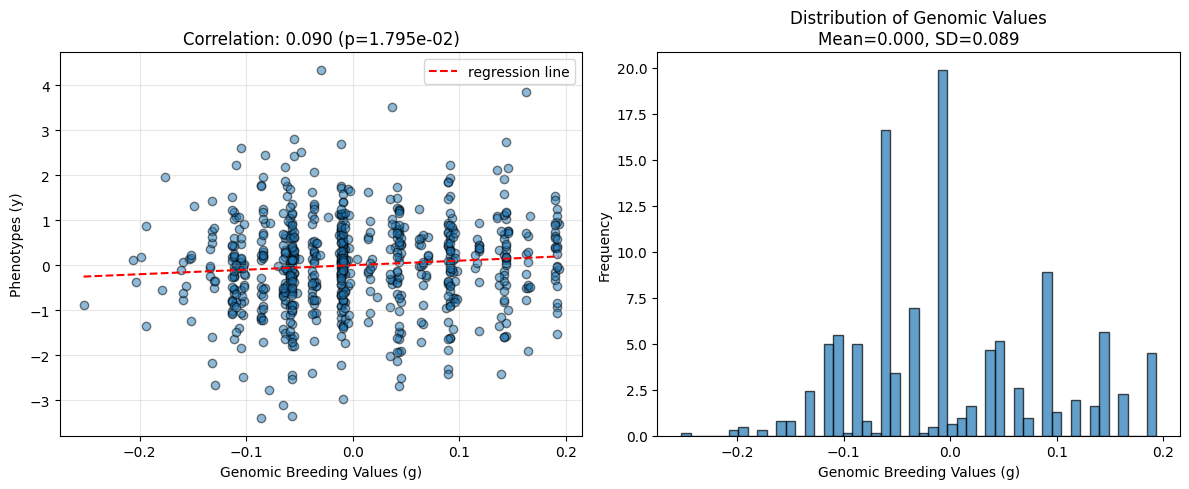

Correlation between genomic breeding values and phenotypes:
Pearson:  r = 0.0898, p = 1.7951e-02
Spearman: ρ = 0.1296, p = 6.1423e-04

Variance proportions:
Fixed effects: 0.80%
Genomic values: 0.80%
Unexplained: 98.40%


In [72]:
def analyze_genomic_correlations(y: np.ndarray, g: np.ndarray, X=None, beta=None, plot=True):
    """
    Calculate correlations between genomic breeding values and phenotypes,
    with optional analysis of fixed effects contribution.
    
    Parameters:
    -----------
    y : np.ndarray
        Observed phenotypes (n x 1)
    g : np.ndarray
        Estimated genomic breeding values (n x 1)
    X : np.ndarray, optional
        Design matrix for fixed effects (n x p)
    beta : np.ndarray, optional
        Fixed effects estimates (p x 1)
    plot : bool, optional
        Whether to create correlation plots (default: True)
        
    Returns:
    --------
    dict : Dictionary of correlation statistics
    """
    results = {}
    
    # Calculate direct correlation between g and y
    pearson_corr, pearson_p = pearsonr(g.flatten(), y.flatten())
    spearman_corr, spearman_p = spearmanr(g.flatten(), y.flatten())
    
    results['g_y_pearson'] = (pearson_corr, pearson_p)
    results['g_y_spearman'] = (spearman_corr, spearman_p)
    
    # Calculate fixed effects contribution if provided
    if X is not None and beta is not None:
        fixed_effects = np.dot(X, beta)
        results['fixed_var'] = np.var(fixed_effects)
        results['random_var'] = np.var(g)
        results['total_var'] = np.var(y)
        
        # Calculate proportion of variance explained
        results['fixed_proportion'] = results['fixed_var'] / results['total_var']
        results['random_proportion'] = results['random_var'] / results['total_var']
    
    # Create plots if requested
    if plot:
        # Plot 1: g vs y
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(g, y, alpha=0.5, edgecolor='k')
        plt.xlabel('Genomic Breeding Values (g)')
        plt.ylabel('Phenotypes (y)')
        plt.title(f'Correlation: {pearson_corr:.3f} (p={pearson_p:.3e})')
        plt.grid(alpha=0.3)
        
        # Add regression line
        m, b = np.polyfit(g.flatten(), y.flatten(), 1)
        x_line = np.linspace(min(g), max(g), 100)
        y_line = m * x_line + b
        plt.plot(x_line, y_line, 'r--', label="regression line")

        # Add y = x line
        # plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', alpha=1, label="y = x line")
        plt.legend()
        
        # Plot 2: Histogram of genomic values
        plt.subplot(1, 2, 2)
        plt.hist(g, bins=50, alpha=0.7, edgecolor='k', density=True)
        plt.xlabel('Genomic Breeding Values (g)')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Genomic Values\nMean={np.mean(g):.3f}, SD={np.std(g):.3f}')
        plt.tight_layout()
        plt.show()
        
    return results

# Run the analysis
corr_results = analyze_genomic_correlations(y_normalized, g, X, beta)

# Print summary
print(f"Correlation between genomic breeding values and phenotypes:")
print(f"Pearson:  r = {corr_results['g_y_pearson'][0]:.4f}, p = {corr_results['g_y_pearson'][1]:.4e}")
print(f"Spearman: ρ = {corr_results['g_y_spearman'][0]:.4f}, p = {corr_results['g_y_spearman'][1]:.4e}")

if 'fixed_proportion' in corr_results:
    print(f"\nVariance proportions:")
    print(f"Fixed effects: {corr_results['fixed_proportion']*100:.2f}%")
    print(f"Genomic values: {corr_results['random_proportion']*100:.2f}%")
    print(f"Unexplained: {(1-corr_results['fixed_proportion']-corr_results['random_proportion'])*100:.2f}%")